# P6 : Clustering automatique des biens de consommation

<p><strong>Contexte :</strong> L'entreprise <strong>Place de marché</strong> souhaite lancer une marketplace e-commerce. Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.</p>

<p><strong>Problématique :</strong> Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit. Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible et dans l'optique d'un passage à l'échelle, <strong>il devient nécessaire d'automatiser cette tâche</strong>.</p>
    
<p><strong>Objectif :</strong> Etudier la faisabilité d'un <strong>moteur de clustering</strong> des articles en différentes catégories, avec un niveau de précision suffisant.</p>
    
<p><strong>Mission :</strong> <strong> Réaliser une première étude de faisabilité d'un moteur de clustering</strong> d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article. Analyser le jeu de données en réalisant :
<ul>
    <li>un <strong>prétraitement</strong> des images et des descriptions des produits,</li>
    <li>une <strong>réduction de dimension</strong>,puis</li>
    <li>un <strong>clustering</strong>. Les résultats du clustering seront présentés sous la forme d’une représentation en deux dimensions à déterminer, qui illustrera le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.</li>
</ul>
</p>

<p><strong>Contrainte :</strong> Afin d’extraire les features, mettre en œuvre a minima un <strong>algorithme de type SIFT / ORB / SURF</strong>. Un algorithme de type CNN Transfer Learning peut éventuellement être utilisé en complément, s’il peut apporter un éclairage supplémentaire à la démonstration.</p>

<hr/>

## I. Importation des Librairies utiles
<p>Plusieurs librairies sont utiles tout au long de l'étude. Elles sont importées dans cette section.</p>

In [1]:
# librairies pour ne pas afficher les warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# librairies pour les certificats
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# librairies pour les graphes
%pylab  inline
import seaborn as sns
from sklearn.manifold import TSNE

Populating the interactive namespace from numpy and matplotlib


### !pip install tensorflow --upgrade --force-reinstall

In [4]:
# librairies pour les analyses
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing, decomposition

In [5]:
# librairies pour les textes
import nltk
from stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow_hub as hub

In [6]:
# librairies pour les images
from matplotlib.image import imread
from PIL import Image
import cv2 as cv2

In [7]:
# librairies pour les modèles
from sklearn import cluster, metrics
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential
from keras.layers import Flatten

<hr/>

## II. Importation des Données

In [8]:
raw_data = pd.read_csv('../Dataset/flipkart_com-ecommerce_sample_1050.csv')

In [9]:
raw_data.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [165]:
raw_data.shape

(1050, 15)

In [160]:
raw_data.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [161]:
raw_data.product_category_tree[0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [162]:
raw_data.description[0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [163]:
raw_data.image[0]

'55b85ea15a1536d46b7190ad6fff8ce7.jpg'

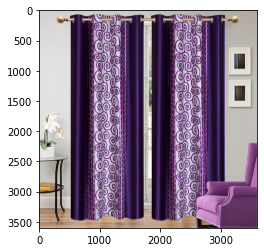

In [164]:
filename = path + raw_data.image[0]
image = imread(filename)
plt.imshow(image)
plt.show()

<hr/>

## III. Traitement des Catégories

In [190]:
raw_data.product_category_tree

0       ["Home Furnishing >> Curtains & Accessories >>...
1       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
                              ...                        
1045    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1046    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1047    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1048    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1049    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
Name: product_category_tree, Length: 1050, dtype: object

In [180]:
long_cat = raw_data['product_category_tree'].unique()

[Text(0, 0, 'Home Furnishing'),
 Text(1, 0, 'Baby Care'),
 Text(2, 0, 'Baby Care'),
 Text(3, 0, 'Home Furnishing'),
 Text(4, 0, 'Home Furnishing'),
 Text(5, 0, 'Watches'),
 Text(6, 0, 'Watches'),
 Text(7, 0, 'Watches'),
 Text(8, 0, 'Watches'),
 Text(9, 0, 'Watches'),
 Text(10, 0, 'Watches'),
 Text(11, 0, 'Watches'),
 Text(12, 0, 'Watches'),
 Text(13, 0, 'Watches'),
 Text(14, 0, 'Watches'),
 Text(15, 0, 'Watches'),
 Text(16, 0, 'Watches'),
 Text(17, 0, 'Watches'),
 Text(18, 0, 'Watches'),
 Text(19, 0, 'Watches'),
 Text(20, 0, 'Watches'),
 Text(21, 0, 'Watches'),
 Text(22, 0, 'Watches'),
 Text(23, 0, 'Watches'),
 Text(24, 0, 'Watches'),
 Text(25, 0, 'Watches'),
 Text(26, 0, 'Watches'),
 Text(27, 0, 'Watches'),
 Text(28, 0, 'Watches'),
 Text(29, 0, 'Home Furnishing'),
 Text(30, 0, 'Home Furnishing'),
 Text(31, 0, 'Home Furnishing'),
 Text(32, 0, 'Home Decor & Festive Needs'),
 Text(33, 0, 'Kitchen & Dining'),
 Text(34, 0, 'Kitchen & Dining'),
 Text(35, 0, 'Home Furnishing'),
 Text(36, 0, 

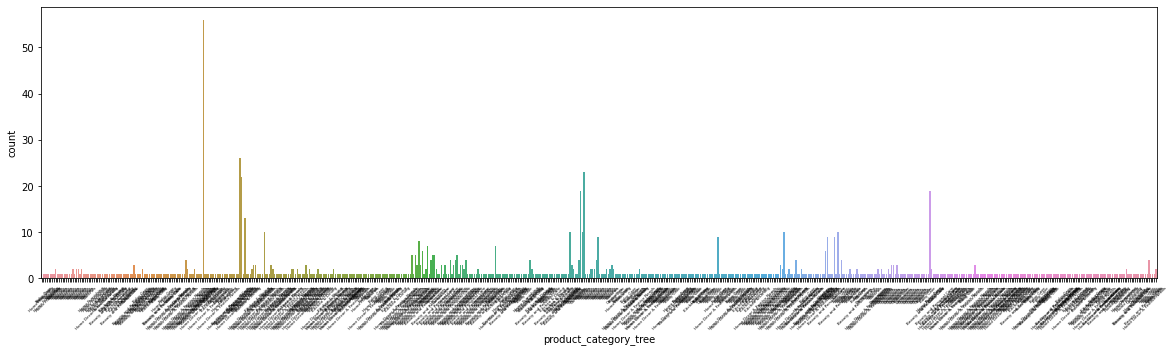

In [192]:
fig, ax1 = plt.subplots(figsize=(20,5))
ax1.xaxis.set_tick_params(rotation=45)
sns.countplot(x="product_category_tree", data=raw_data, ax=ax1)
ax1.set_xticklabels([text[2:text.find('>')-1] for text in long_cat],fontsize=4)

<p>Les données concernant la <strong>"réelle"</strong> catégorie des produits sont données dans la colonne <strong>"product_category_tree"</strong> qui contient plusieurs données textes hierarchisant la catégorie et le type de produit. On voit que ces données sont trop riche pour permettre une bonne catégorisation des produits.</p>
<p>On choisit de ne s'intéresser qu'au premier élément de l'arborescence. Une étape d'extraction est alors nécessaire et ces données seront contenues dans une nouvelle colonne <strong>"product_category"</strong>.</p>

In [193]:
raw_data['product_category'] = raw_data['product_category_tree'].apply(lambda text : text[2:text.find('>')-1])

Text(0, 0.5, 'count')

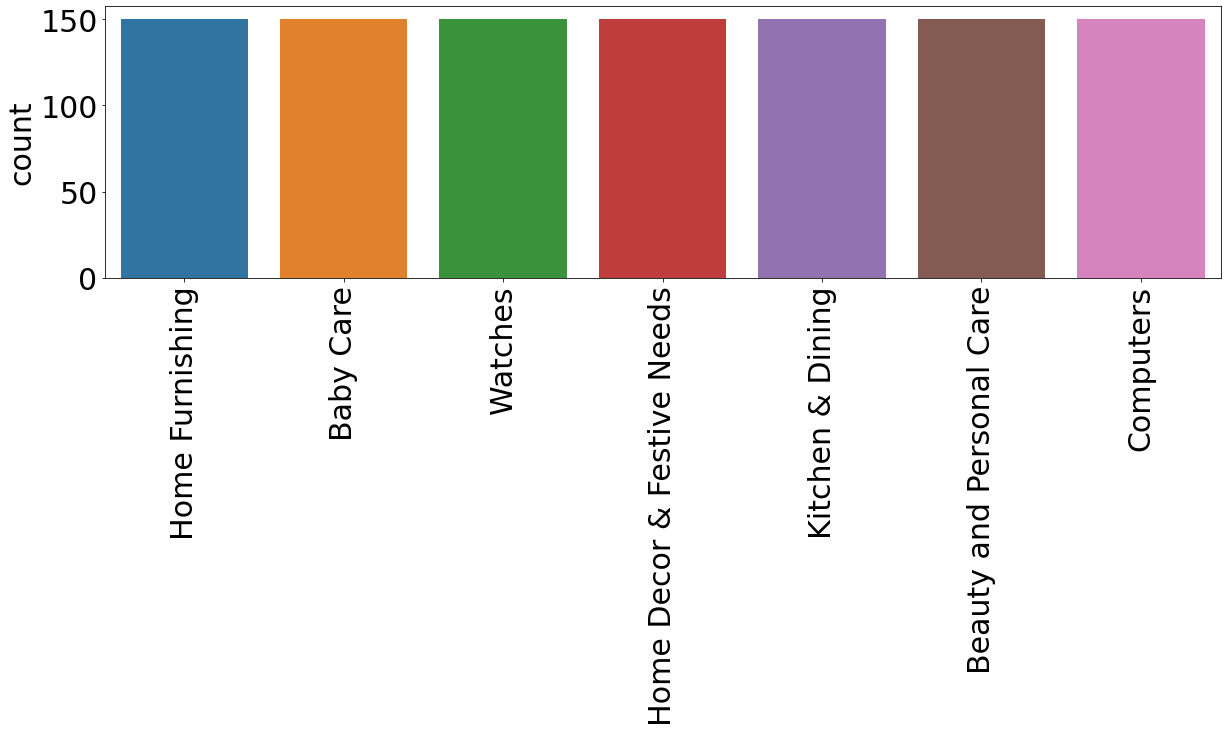

In [211]:
fig, ax1 = plt.subplots(figsize=(20,5))
ax1.xaxis.set_tick_params(labelsize=30,rotation=90)
ax1.yaxis.set_tick_params(labelsize=30)
sns.countplot(x="product_category", data=raw_data, ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('count',fontsize=30)

<hr/>

## IV. Traitement des Données Textes

### 1. Extraction des données d'intérêt

<p>Les données qui nous intéressent sont les données concernant la catégorie des produits et leurs descriptions. On se focalisera alors sur ces 2 colonnes uniquement pour cette partie.</p>

In [215]:
data_text = raw_data[['product_category','description']]

In [216]:
le = preprocessing.LabelEncoder()
data_text['label'] = le.fit_transform(data_text['product_category'])

In [217]:
data_text = data_text[['label','product_category','description']]

### 2. Nettoyage des données

In [220]:
def cleanText(text,lowercase=False,tokenization=False,remove_stops=False,lemmatization=False):
    
    txt = str(text) 
    txt = re.sub(r'[^A-Za-z\s]',r' ',txt)    
    
    # changement en minuscule
    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])
    
    # tokenization
    if tokenization:
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        txt = " ".join([w for w in txt.split() if w in tokenizer.tokenize(txt)])
    
    # nettoyage : suppression des stop words
    if remove_stops:
        stopWords = list(get_stop_words('en'))
        nltkWords = list(stopwords.words('english'))
        stopWords.extend(nltkWords)
        txt = " ".join([w for w in txt.split() if w not in stopWords and len(w)>2])
    
    # normalisation : lemmatization
    if lemmatization:
        wordnet_lemmatizer = WordNetLemmatizer()
        txt = " ".join([wordnet_lemmatizer.lemmatize(w, pos='v') for w in txt.split()])

    return txt

In [221]:
data_text['description'] = data_text['description'].map(lambda x: cleanText(x,lowercase=True,tokenization=True,
                                                                              remove_stops=True,lemmatization=True))

In [222]:
data_text.head(3)

,label,product_category,description
0,4,Home Furnishing,key feature elegance polyester multicolor abst...
1,0,Baby Care,specifications sathiyas cotton bath towel bath...
2,0,Baby Care,key feature eurospa cotton terry face towel se...


In [223]:
data_text.description[0]

'key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height pack price curtain enhance look interiors curtain make high quality polyester fabric feature eyelet style stitch metal ring make room environment romantic love curtain ant wrinkle anti shrinkage elegant apparance give home bright modernistic appeal design surreal attention sure steal hearts contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close even create special moments joyous beauty give soothe print bring home elegant curtain softly filter light room get right amount sunlight specifications elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance design door type eyelet model name abstract polyester door curtain set model duster color multicolor dimension length box number content sales package pack s

### 3. Clustering des données textes

In [250]:
labels = data_text['label']
cats = data_text['product_category']

In [225]:
labels.unique()

array([4, 0, 6, 3, 5, 1, 2])

<p>Il y a 7 catégories de produits. On choisira donc pour le clustering <strong>n_clusters=7</strong>.</p>

In [226]:
def clustering(values,labels,n_clusters=7):    
    # modele kmeans
    kmeans = KMeans(n_clusters=n_clusters).fit(values)
    kmeans_labels = kmeans.labels_
    
    # evaluation
    kmeans_silhouet = metrics.silhouette_score(values,kmeans_labels)
    kmeans_daviesbouldin = metrics.davies_bouldin_score(values,kmeans_labels)
    kmeans_ari = adjusted_rand_score(labels,kmeans_labels)
    
    return (kmeans_labels,kmeans_silhouet,kmeans_daviesbouldin,kmeans_ari)

#### a. Clustering avec "Bag of words"

- Représentation en "BAG OF WORDS" : TFIDF (selon Fréquences & Poids des mots)

In [227]:
Tfidf = TfidfVectorizer()
Tfidf_data = Tfidf.fit_transform(data_text['description'])

In [228]:
Tfidf_df = pd.DataFrame(Tfidf_data.toarray(),columns=Tfidf.get_feature_names())

In [229]:
Tfidf_df.head(3)

,aaa,aapno,aari,aarika,abide,abilities,ability,abkl,able,abrasions,...,zikrak,zinc,zingalalaa,zip,zipexterior,zipper,zone,zoom,zora,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [230]:
Tfidf_df.shape

(1050, 4314)

* Réduction de dimension

In [231]:
print("Dimensions dataset avant réduction PCA : ", Tfidf_df.shape)
pca = decomposition.PCA(n_components=0.99)
Tfidf_pca = pca.fit_transform(Tfidf_df)
print("Dimensions dataset après réduction PCA : ", Tfidf_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4314)
Dimensions dataset après réduction PCA :  (1050, 791)


- Initialisation des données

In [232]:
values = Tfidf_pca

In [233]:
tsne = TSNE(n_components=2)
z = tsne.fit_transform(values)

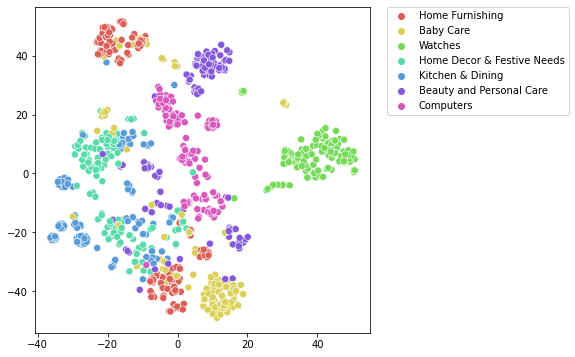

In [251]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x=z[:,0],y=z[:,1],hue=cats,palette=sns.color_palette("hls", 7),s=50)
plt.legend(bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)

- Clustering kmeans

In [235]:
kmeans_labels,kmeans_silhouet,kmeans_daviesbouldin,kmeans_ari = clustering(values=values,labels=labels)

In [236]:
print("Silhouette Coefficient: %0.3f"% kmeans_silhouet)
print("Score Davies Bouldin: %0.3f"% kmeans_daviesbouldin)
print("ARI: %0.3f"% kmeans_ari)

Silhouette Coefficient: 0.060
Score Davies Bouldin: 4.375
ARI: 0.281


Les scores du modèle ne sont pas bonnes. L'ARI montre également que les labels prevenant du kmeans n'est pas équivalent aux catégories des produits.

- Visualisation 2D

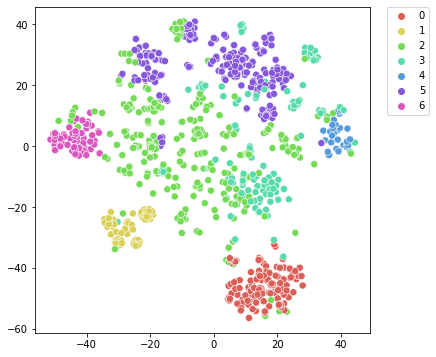

In [237]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x=z[:,0],y=z[:,1],hue=kmeans_labels,palette=sns.color_palette("hls", 7),s=50)
plt.legend(bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)

On voit sur la figure que les points ne sont pas bien groupés.

#### b. Clustering avec "words embedding"

- Représentation en "WORDS EMBEDDING" : USE (plongement des mots dans un espace de 512 dimensions)

In [238]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [239]:
embed_data = embed(data_text['description'])

In [240]:
embed_df = pd.DataFrame(embed_data.numpy())

In [241]:
embed_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.053409,-0.053755,0.005996,0.051688,-0.013113,0.048114,-0.024108,0.049812,-0.035168,-0.011691,...,-0.021008,-0.053990,-0.053589,0.053384,0.010053,-0.051934,0.044208,0.047368,0.043895,-0.015910
1,-0.048651,-0.049992,-0.008068,0.044625,0.051083,0.059246,0.051602,-0.041411,-0.036145,-0.046453,...,0.017058,-0.059093,-0.046367,-0.048076,-0.001813,-0.051985,0.009366,0.037771,0.020482,0.014286
2,-0.053827,-0.050586,-0.013539,0.053693,0.051161,0.053597,0.049655,0.030850,-0.046326,0.024244,...,0.036250,-0.053930,-0.048848,0.029378,0.048830,-0.053687,0.047154,0.051735,-0.037502,-0.047805


In [242]:
embed_df.shape

(1050, 512)

* Réduction de dimension

In [243]:
print("Dimensions dataset avant réduction PCA : ", embed_df.shape)
pca = decomposition.PCA(n_components=0.99)
embed_pca = pca.fit_transform(embed_df)
print("Dimensions dataset après réduction PCA : ", embed_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 512)
Dimensions dataset après réduction PCA :  (1050, 318)


- Initialisation des données

In [244]:
values = embed_pca

In [245]:
tsne = TSNE(n_components=2)
z = tsne.fit_transform(values)

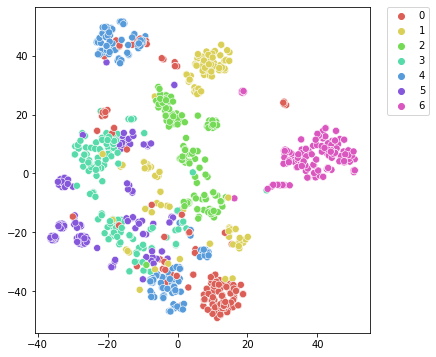

In [246]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x=z[:,0],y=z[:,1],hue=labels,palette=sns.color_palette("hls", 7),s=50)
plt.legend(bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)

- Clustering kmeans

In [247]:
kmeans_labels,kmeans_silhouet,kmeans_daviesbouldin,kmeans_ari = clustering(values=values,labels=labels)

In [248]:
print("Silhouette Coefficient: %0.3f"% kmeans_silhouet)
print("Score Davies Bouldin: %0.3f"% kmeans_daviesbouldin)
print("ARI: %0.3f"% kmeans_ari)

Silhouette Coefficient: 0.108
Score Davies Bouldin: 2.702
ARI: 0.325


Les scores du modèle ne sont pas bonnes. L'ARI montre également que les labels prevenant du kmeans n'est pas équivalent aux catégories des produits.

- Visualisation 2D

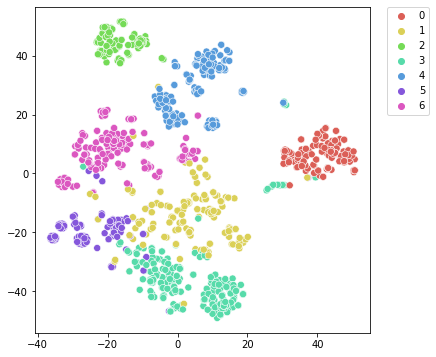

In [249]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x=z[:,0],y=z[:,1],hue=kmeans_labels,palette=sns.color_palette("hls", 7),s=50)
plt.legend(bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)

<hr/>

## V. Traitement des Images

### 1. Extraction des données d'intérêt

<p>Les données qui nous intéressent sont les données concernant la catégorie des produits et les images correspodants. On se focalisera alors sur ces 2 colonnes uniquement pour cette partie.</p>

In [43]:
data_img = raw_data[['product_category','image']]

In [45]:
le = preprocessing.LabelEncoder()
data_img['label'] = le.fit_transform(data_img['product_category'])

In [46]:
data_img = data_img[['label','product_category','image']]

In [47]:
data_img.head(3)

,label,product_category,image
0,4,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,0,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,0,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg


### 2. Affichage d'exemples d'images par label

In [48]:
path = '../Dataset/Images/'
list_photos = data_img['image']

In [49]:
data_img['product_category'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [50]:
def list_fct(cat) :
    list_image_cat = list(data_img['image'][data_img['product_category']==cat])
    return list_image_cat

In [51]:
list_furnish = list_fct('Home Furnishing')
list_baby = list_fct('Baby Care')
list_watch = list_fct('Watches')
list_decor = list_fct('Home Decor & Festive Needs')
list_kitchen = list_fct('Kitchen & Dining')
list_beauty = list_fct('Beauty and Personal Care')
list_pc = list_fct('Computers')

Home Furnishing


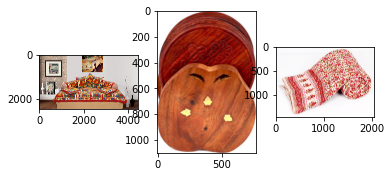

Baby Care


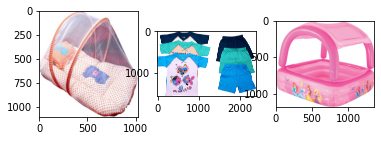

Watches


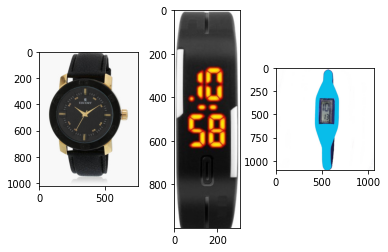

Home Decor & Festive Needs


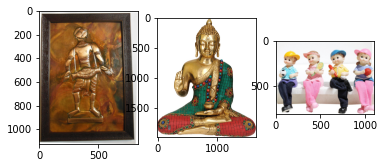

Kitchen & Dining


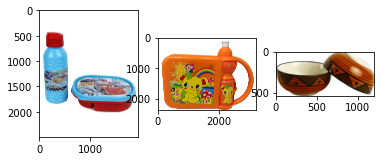

Beauty and Personal Care


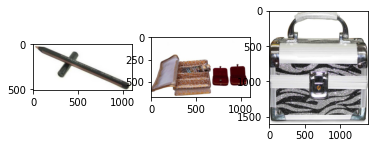

Computers


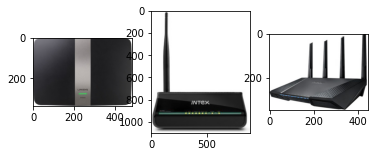

In [52]:
for cat in data_img['product_category'].unique() :
    print(cat)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(cat)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

### 3. Clustering avec détection des features via SIFT / ORB

#### 3.1. Pré-traitement des images

In [53]:
def treat_img(imgName):
    # Chargement des images & conversion en gray
    img = cv2.imread(path + imgName,0)
    # Redimensionnement des images
    img = cv2.resize(img, (240,240), interpolation = cv2.INTER_AREA)
    # Egalisation de l'histogramme    
    img = cv2.equalizeHist(img)
    # Réduction des bruits
    img = cv2.GaussianBlur(img, (3,3), cv2.BORDER_DEFAULT)
    img = cv2.medianBlur(img, 3)
    
    return img

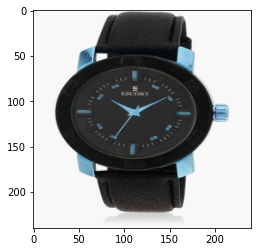

In [345]:
img = cv2.imread(path + list_photos[15])
img = cv2.resize(img, (240,240), interpolation = cv2.INTER_AREA)
plt.imshow(img)

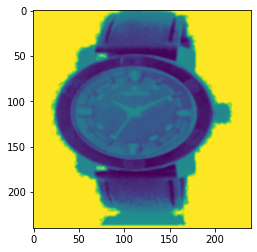

In [341]:
img = treat_img(list_photos[15])
plt.imshow(img)

In [56]:
imgTreat = []
for imgNum in range(len(list_photos)) :
    imgTreat.append(treat_img(list_photos[imgNum]))

In [289]:
list_fct('Watches')[11]

'5479bb7028827d60000720a2c135976a.jpg'

Home Furnishing


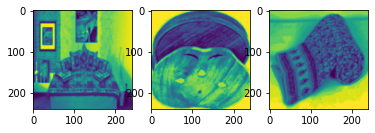

Baby Care


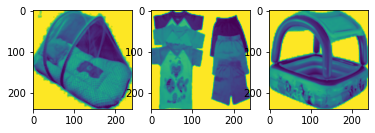

Watches


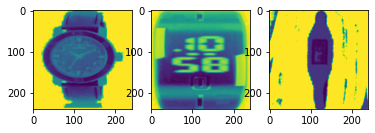

Home Decor & Festive Needs


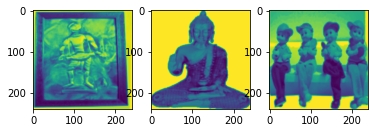

Kitchen & Dining


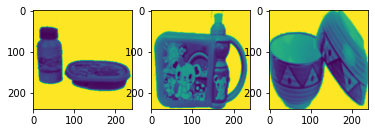

Beauty and Personal Care


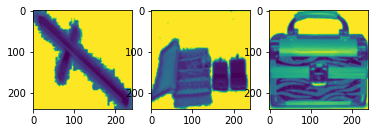

Computers


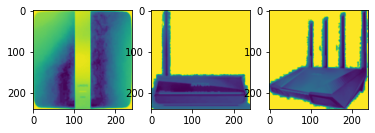

In [267]:
for cat in data_img['product_category'].unique() :
    print(cat)
    # print("-------")
    for i in range(3):
        ix = data_img[(data_img['product_category']==cat) & (data_img['image']==list_fct(cat)[i+10])].index[0]
        plt.subplot(130 + 1 + i)
        image = imgTreat[ix]
        plt.imshow(image)
    plt.show()

#### 3.2. SIFT

In [57]:
sift = cv2.xfeatures2d.SIFT_create()

##### a. Pré-traitement des images & Extraction des descripteurs

* Pour une image

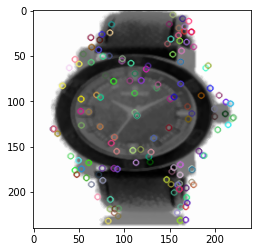

Descripteurs :  (151, 128)

[[ 69.  54.   0. ...   0.   0.   0.]
 [ 72.  38.   0. ...   0.   0.   0.]
 [135.  89.   0. ...   0.   0.   2.]
 ...
 [ 55. 137.   5. ...   0.   0.   3.]
 [ 77.  68.   2. ...   0.   0.   0.]
 [ 21. 101. 143. ...   0.   0.   0.]]


In [342]:
# Chargement de l'image pré-traité
img = treat_img(list_photos[15])
# Extraction des features / caractéristiques de l'image via SIFT
kp, des = sift.detectAndCompute(img, None)
img=cv2.drawKeypoints(img,kp,img)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

L'image contient 151 descripteurs et chaque descripteur est un vecteur de longueur 128.

Créations des descripteurs de chaque image : 
<p>- Passage en gris et equalisation</p>
<p>- création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes</p>
<p>- création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs</p>

* Pour l'ensemble des images

In [59]:
sift_kp = []

for imgNum in range(len(list_photos)) :
    # Chargement des images pré-traités
    img = imgTreat[imgNum]
    # Extraction des features / caractéristiques de l'image à l'aide d'ORB
    kp, des = sift.detectAndCompute(img, None)
    sift_kp.append(des)

sift_kp_by_img = np.asarray(sift_kp)
sift_kp_all    = np.concatenate(sift_kp_by_img, axis=0)

In [60]:
print("Nombre de descripteurs : ", sift_kp_all.shape)

Nombre de descripteurs :  (303338, 128)


##### b) Créations des clusters de descripteurs : BAG OF VISUAL WORDS

* Détermination du nombre de clusters

In [61]:
k = int(round(np.sqrt(len(sift_kp_all)),0))
print("Nombre de clusters estimés : ", k)

Nombre de clusters estimés :  551


* Clustering

In [62]:
print("Création de",k, "clusters de descripteurs ...")
kmeans_features = cluster.MiniBatchKMeans(n_clusters=k,init_size=3*k,random_state=0).fit(sift_kp_all)

Création de 551 clusters de descripteurs ...


* Matrice des descripteurs

In [63]:
# Creation of histograms (features)
def build_histogram(kmeans, des, imgNum):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", imgNum)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

In [64]:
# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_kp_by_img) :
    hist = build_histogram(kmeans_features, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_Feature = np.asarray(hist_vectors)

In [65]:
Tfidf_sift = pd.DataFrame(im_Feature)

In [66]:
Tfidf_sift.head(3)

,0,1,2,3,4,5,6,7,8,9,...,541,542,543,544,545,546,547,548,549,550
0,0.000000,0.002667,0.0,0.0,0.002667,0.005333,0.010667,0.002667,0.000000,0.0,...,0.0,0.021333,0.005333,0.0,0.0,0.002667,0.000000,0.0,0.0,0.005333
1,0.004695,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.004695,0.014085,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.004695,0.004695,0.0,0.0,0.000000
2,0.000000,0.002326,0.0,0.0,0.000000,0.000000,0.002326,0.002326,0.002326,0.0,...,0.0,0.002326,0.000000,0.0,0.0,0.002326,0.002326,0.0,0.0,0.000000


* Réduction de dimension

In [126]:
print("Dimensions dataset avant réduction PCA : ", Tfidf_sift.shape)
pca = decomposition.PCA(n_components=0.99)
Tfidf_sift_pca = pca.fit_transform(Tfidf_sift)
print("Dimensions dataset après réduction PCA : ", Tfidf_sift_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 551)
Dimensions dataset après réduction PCA :  (1050, 450)


##### c. Clustering des images

* Initialisation des données pour le clustering

In [127]:
values = Tfidf_sift_pca
labels = data_img['label']

In [128]:
z = tsne.fit_transform(values)

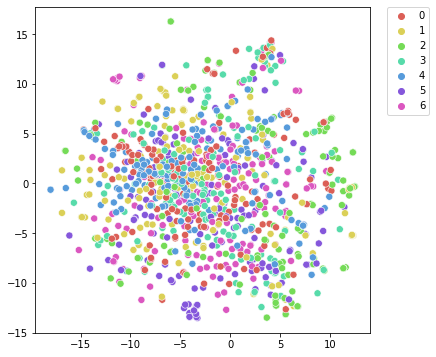

In [129]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x=z[:,0],y=z[:,1],hue=labels,palette=sns.color_palette("hls", 7),s=50)
plt.legend(bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)

* Clustering kmeans

In [130]:
kmeans_labels,kmeans_silhouet,kmeans_daviesbouldin,kmeans_ari = clustering(values=values,labels=labels)

In [131]:
print("Silhouette Coefficient: %0.3f"% kmeans_silhouet)
print("Score Davies Bouldin: %0.3f"% kmeans_daviesbouldin)
print("ARI: %0.3f"% kmeans_ari)

Silhouette Coefficient: 0.169
Score Davies Bouldin: 2.058
ARI: 0.011


-> Les scores du modèle ne sont pas bonnes. L'ARI montre également que les labels prevenant du kmeans n'est pas équivalent aux catégories des produits.

* Visualisation 2D

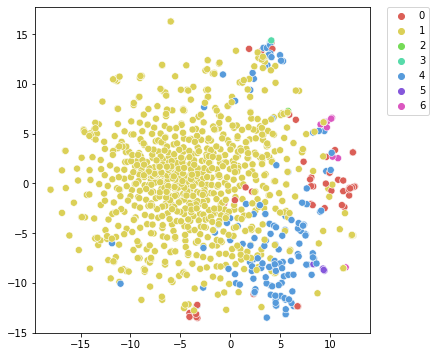

In [132]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x=z[:,0],y=z[:,1],hue=kmeans_labels,palette=sns.color_palette("hls", 7),s=50)
plt.legend(bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)

On voit sur la figure que les points ne sont pas bien groupés.

#### 3.3. ORB

##### a. Pré-traitement des images & Extraction des descripteurs

In [74]:
orb = cv2.ORB_create()

* Pour une image

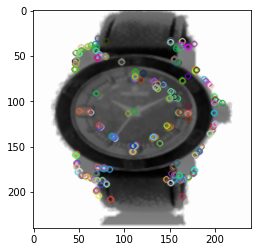

Descripteurs :  (271, 32)

[[ 90  73 254 ... 254  33  89]
 [ 63  93 163 ... 127 248 212]
 [ 72 154 250 ... 196 173 123]
 ...
 [ 78 189 161 ... 119   7 118]
 [249 228 115 ... 136  66  40]
 [165 164  29 ...   1  74 162]]


In [343]:
# Chargement de l'image pré-traité
img = treat_img(list_photos[15])
# Extraction des features / caractéristiques de l'image via ORB
kp,des = orb.detectAndCompute(img, None)

img=cv2.drawKeypoints(img,kp,img)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

* Pour l'ensemble des images

In [76]:
allFeatures=[]
imgNoDescr=[]

for imgNum in range(len(list_photos)):
    # Chargement des images pré-traité
    img = imgTreat[imgNum]
    # Extraction des features / caractéristiques de l'image via ORB
    keypoints, descriptors = orb.detectAndCompute(img, None)
    if descriptors is not None:
        allFeatures.append(descriptors)
    else :
        imgNoDescr.append(imgNum)

<strong>!!! Images n'ayant pas de descripteurs :</strong>

In [77]:
imgNoDescr

[]

In [78]:
for i in range(len(imgNoDescr)):
    plt.subplot(121 + i)
    filename = path + list_photos[imgNoDescr[i]]
    image = imread(filename)
    plt.imshow(image)
    plt.title(list_photos[imgNoDescr[i]])

In [79]:
pad = len(max(allFeatures, key=len))
allFeatures_pad = np.array([np.pad(i, ((0,pad-len(i)),(0,0))) for i in allFeatures])

In [80]:
descriptors_by_img = np.asarray(allFeatures_pad)
descriptors_all    = np.concatenate(descriptors_by_img, axis=0)

In [81]:
descriptors_all.shape

(479850, 32)

##### b) Créations des clusters de descripteurs : BAG OF VISUAL WORDS

* Détermination du nombre de clusters

In [82]:
k = int(round(np.sqrt(len(descriptors_all))))
print("Nombre de clusters estimés : ", k)

Nombre de clusters estimés :  693


* Clustering des descripteurs

In [83]:
print("Création de",k, "clusters de descripteurs ...")
kmeans_features = cluster.MiniBatchKMeans(n_clusters = k,init_size=3*k,random_state=0).fit(descriptors_all)

Création de 693 clusters de descripteurs ...


* Calcule TF et du nombre d'images par feature

In [84]:
im_Feature=[0] * k

allTF=[]
for i in allFeatures_pad:
    clusters=[]
    for u in i:
        cluster=kmeans_features.predict([u])  
        clusters.append(cluster[0])
        
    nums=pd.Series(clusters).value_counts()
    tf=nums.apply(lambda a:a/nums.sum())
    allTF.append(tf.to_dict())
#tf for each feature in the document

for i in allTF:
    for j in i:
        im_Feature[j-1]=im_Feature[j-1]+1
#number of documents containing a given feature

* Calcule TF IDF - Creation du bag of Visual Words

In [85]:
Tfidf_orb = pd.DataFrame(columns= range(1,k+1))
for i in allTF:
    row=[0]*k
    totalWords=0
    for j in i:
        idf=math.log(len(allTF)/im_Feature[j-1])
        res=i[j]*idf
        row[j]=res
    Tfidf_orb = Tfidf_orb.append(pd.Series(row, range(1,k+1)),ignore_index=True ) 

In [86]:
Tfidf_orb.head(3)

,1,2,3,4,5,6,7,8,9,10,...,684,685,686,687,688,689,690,691,692,693
0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.002429,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.002628,0.000000,0.000000
1,0.0,0.0,0.0,0.003846,0.00000,0.00000,0.000000,0.001984,0.0,0.004922,...,0.000000,0.004506,0.0,0.006761,0.0,0.000000,0.0,0.000000,0.006684,0.002342
2,0.0,0.0,0.0,0.000000,0.00429,0.00258,0.002429,0.000000,0.0,0.000000,...,0.002526,0.000000,0.0,0.000000,0.0,0.002047,0.0,0.000000,0.003342,0.000000


* Réduction de dimension

In [133]:
print("Dimensions dataset avant réduction PCA : ", Tfidf_orb.shape)
pca = decomposition.PCA(n_components=0.99)
Tfidf_orb_pca = pca.fit_transform(Tfidf_orb)
print("Dimensions dataset après réduction PCA : ", Tfidf_orb_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 693)
Dimensions dataset après réduction PCA :  (1050, 548)


##### c. Clustering des images

* Initialisation des données pour le clustering

In [134]:
values = Tfidf_orb_pca
labels = data_img['label'].drop(imgNoDescr)

In [135]:
z = tsne.fit_transform(values)

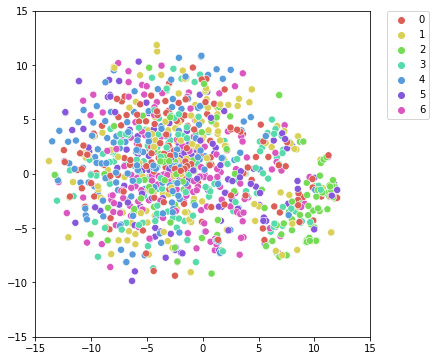

In [138]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x=z[:,0],y=z[:,1],hue=labels,palette=sns.color_palette("hls", 7),s=50)
plt.xlim([-15,15])
plt.ylim([-15,15])
plt.legend(bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)

* Clustering kmeans

In [139]:
kmeans_labels,kmeans_silhouet,kmeans_daviesbouldin,kmeans_ari = clustering(values=values,labels=labels)

In [140]:
print("Silhouette Coefficient: %0.3f"% kmeans_silhouet)
print("Score Davies Bouldin: %0.3f"% kmeans_daviesbouldin)
print("ARI: %0.3f"% kmeans_ari)

Silhouette Coefficient: 0.026
Score Davies Bouldin: 2.438
ARI: 0.028


-> Les scores du modèle ne sont pas bonnes. L'ARI montre également que les labels prevenant du kmeans n'est pas équivalent aux catégories des produits.

* Visualisation 2D

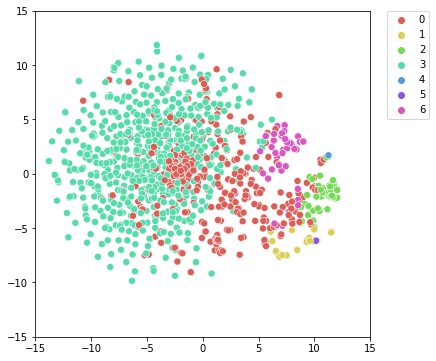

In [141]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x=z[:,0],y=z[:,1],hue=kmeans_labels,palette=sns.color_palette("hls", 7),s=50)
plt.xlim([-15,15])
plt.ylim([-15,15])
plt.legend(bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)

On voit sur la figure que les points ne sont pas bien groupés.

### 4. Clustering avec détection des features par réseaux de neurones : CNN

#### 4.1. RESNET50

##### a. Initialisation du modèle RESNET

In [94]:
resnetModel = ResNet50(weights ='imagenet',include_top=False)

In [95]:
resnetModel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

##### b. Extraction des Features

In [96]:
def getFeatureVector(model,modelName,img_name):
    img = cv2.imread(path + img_name)
    img = cv2.resize(img, (240,240), interpolation = cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if modelName == 'vgg':
        img = preprocess_input(img) # preprocess image as required for VGG16
    feature_vector = model.predict(img.reshape(1,240,240,3)).reshape(-1)
    return feature_vector

In [97]:
resnetFeatures=[]
resnetNoDescr=[]

for imgNum in range(len(list_photos)):
    imgName = list_photos[imgNum]
    descriptors = getFeatureVector(resnetModel,'resnet',imgName)
    if descriptors is not None:
        resnetFeatures.append(descriptors)
    else :
        resnetNoDescr.append(imgNum)

In [98]:
resnetNoDescr

[]

Tous les images ont des descripteurs.

In [99]:
resnetFeatures=np.asarray(resnetFeatures)

* Réduction de dimension

In [142]:
print("Dimensions dataset avant réduction PCA : ", resnetFeatures.shape)
pca = decomposition.PCA(n_components=0.99)
resnetFeatures_pca = pca.fit_transform(resnetFeatures)
print("Dimensions dataset après réduction PCA : ", resnetFeatures_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 131072)
Dimensions dataset après réduction PCA :  (1050, 976)


##### c. Clustering

* Initialisation des données pour le clustering

In [143]:
values = resnetFeatures_pca
labels = data_img['label']

In [144]:
z = tsne.fit_transform(values)

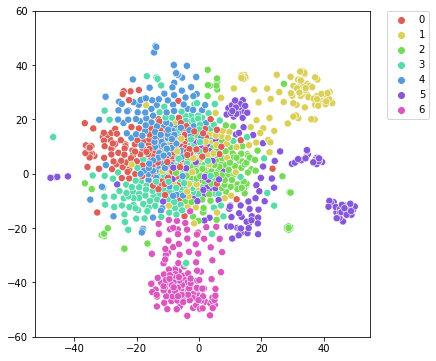

In [149]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x=z[:,0],y=z[:,1],hue=labels,palette=sns.color_palette("hls", 7),s=50)
plt.ylim([-60,60])
plt.legend(bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)

* Clustering kmeans

In [150]:
kmeans_labels,kmeans_silhouet,kmeans_daviesbouldin,kmeans_ari = clustering(values=values,labels=labels)

In [151]:
print("Silhouette Coefficient: %0.3f"% kmeans_silhouet)
print("Score Davies Bouldin: %0.3f"% kmeans_daviesbouldin)
print("ARI: %0.3f"% kmeans_ari)

Silhouette Coefficient: -0.018
Score Davies Bouldin: 4.253
ARI: 0.133


-> Les scores du modèle ne sont pas bonnes. L'ARI montre également que les labels prevenant du kmeans n'est pas équivalent aux catégories des produits.

* Visualisation 2D

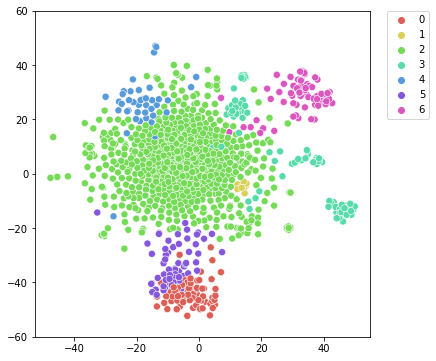

In [152]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x=z[:,0],y=z[:,1],hue=kmeans_labels,palette=sns.color_palette("hls", 7),s=50)
plt.ylim([-60,60])
plt.legend(bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)

On voit sur la figure que les points ne sont pas bien groupés.

#### 4.2. VGG16

##### a. Initialisation du modèle VGG16

In [107]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
vggModel = VGG16(weights="imagenet", include_top=False, input_shape=(240, 240, 3))

In [108]:
vggModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

##### b. Extraction des Features

In [109]:
vggFeatures=[]
vggNoDescr=[]

for imgNum in range(len(list_photos)):
    imgName = list_photos[imgNum]
    descriptors = getFeatureVector(vggModel,'vgg',imgName)
    if descriptors is not None:
        vggFeatures.append(descriptors)
    else :
        vggNoDescr.append(imgNum)

In [110]:
vggNoDescr

[]

Tous les images ont des descripteurs.

In [111]:
vggFeatures=np.asarray(vggFeatures)

* Réduction de dimension

In [153]:
print("Dimensions dataset avant réduction PCA : ", vggFeatures.shape)
pca = decomposition.PCA(n_components=0.99)
vggFeatures_pca = pca.fit_transform(vggFeatures)
print("Dimensions dataset après réduction PCA : ", vggFeatures_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 25088)
Dimensions dataset après réduction PCA :  (1050, 939)


##### c. Clustering

* Initialisation des données pour le clustering

In [154]:
values = vggFeatures_pca
labels = data_img['label']

In [155]:
z = tsne.fit_transform(values)

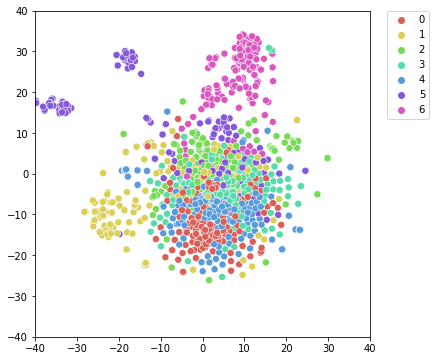

In [156]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x=z[:,0],y=z[:,1],hue=labels,palette=sns.color_palette("hls", 7),s=50)
plt.xlim([-40,40])
plt.ylim([-40,40])
plt.legend(bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)

* Clustering kmeans

In [157]:
kmeans_labels,kmeans_silhouet,kmeans_daviesbouldin,kmeans_ari = clustering(values=values,labels=labels)

In [158]:
print("Silhouette Coefficient: %0.3f"% kmeans_silhouet)
print("Score Davies Bouldin: %0.3f"% kmeans_daviesbouldin)
print("ARI: %0.3f"% kmeans_ari)

Silhouette Coefficient: 0.018
Score Davies Bouldin: 4.105
ARI: 0.214


-> Les scores du modèle ne sont pas bonnes. L'ARI montre également que les labels prevenant du kmeans n'est pas équivalent aux catégories des produits.

* Visualisation 2D

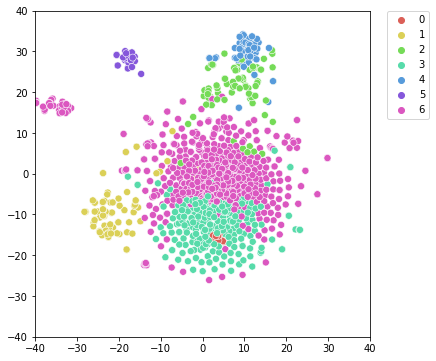

In [159]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x=z[:,0],y=z[:,1],hue=kmeans_labels,palette=sns.color_palette("hls", 7),s=50)
plt.xlim([-40,40])
plt.ylim([-40,40])
plt.legend(bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)

On voit sur la figure que les points ne sont pas bien groupés.

---